Data from https://www.kaggle.com/ealaxi/paysim1

In [54]:
#Imports (importing lots of things, may not use some, but getting them on in case)
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import BayesianRidge, Lasso, LinearRegression, Ridge, RidgeCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from random import seed,sample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#For NNs
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import keras
from keras.models import Sequential
from keras.layers import Dense

In [2]:
df=pd.read_csv('mobilepaymentfraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# What's what
step - Units on 1 hour intevals

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - value of transaction in local currency

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance of recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance of recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - An illegal attempt in this dataset is an attempt to transfer more than 200,000 in a single transaction.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


'type' will need to be encoded.
'nameOrig' and 'nameDest' will also either need ammending somehow into numeric data, or removed from the data before modelling if not needed.

In [10]:
df.isnull().values.any()

False

There are no null values

In [4]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


<AxesSubplot:>

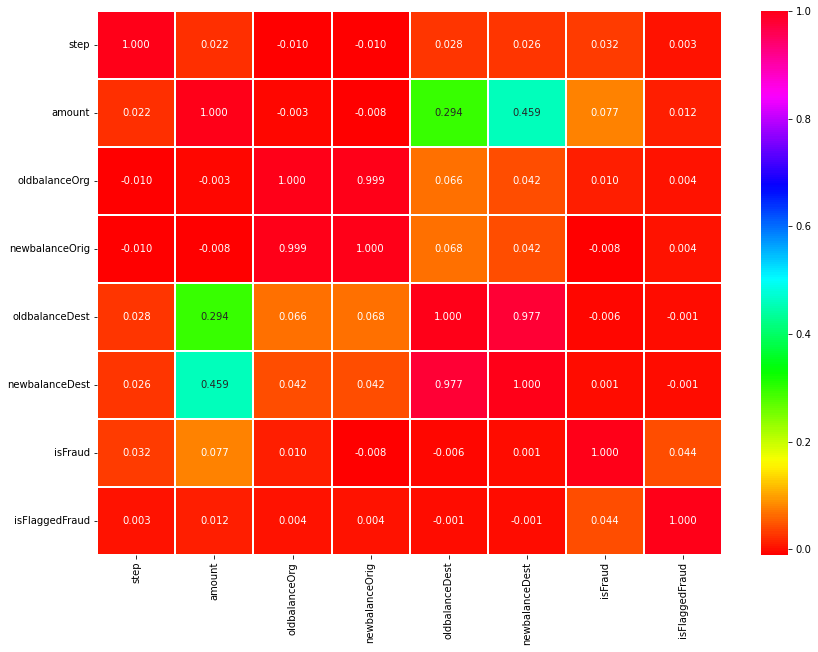

In [7]:
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(),annot=True,cmap='hsv',fmt='.3f',linewidths=2)

The only highly correlated features are newbalanceOrig with oldbalanceOrg, and newbalanceDest with oldbalanceDest - this make sense, as the new values will always be less/more by the value of the transaction

In [8]:
df.groupby('isFraud').mean()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud
isFraud,,,,,,,
0,243.235663,1.781970e+05,8.328287e+05,855970.228109,1.101421e+06,1.224926e+06,0.000000
1,368.413856,1.467967e+06,1.649668e+06,192392.631836,5.442496e+05,1.279708e+06,0.001948


In [11]:
df.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

Only 0.13% of all transactions are fraudulent

In [13]:
print(list(df.loc[(df.isFraud==1)].type.unique())) #What types of transactions are frauddf

['TRANSFER', 'CASH_OUT']


Only TRANSFER and CASH_OUT transactions contain instances of fraud

In [41]:
fraud = df[(df['isFraud'] == 1)]
valid = df[(df['isFraud'] == 0)]

C:\Users\matt_\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


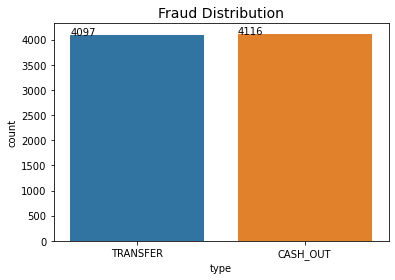

In [36]:
ax=sns.countplot('type', data=fraud)
plt.title('Fraud Distribution', fontsize=14)
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()))), (p.get_x(), p.get_height()))

plt.show()

In [39]:
#investigating merchant accounts
print('Any transactions originate from merchant accounts?', df.nameOrig.str.contains('M').any())


Any transactions originate from merchant accounts? False


In [40]:
print('Any transactions going to merchants other than payments?', (df.loc[df.nameDest.str.contains('M')].type != 'PAYMENT').any())


Any transactions going to merchants other than payments? False


The only transactions Merchants are involved in is recieving payments, and as there is no fraud in payments, differentiating between merchant and customer accounts shouldn't make a difference to the model, so nameOrig and nameDest gettings dropped shouldn't impact a prediction model.

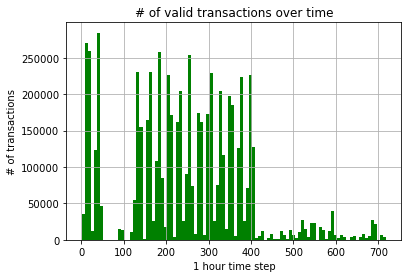

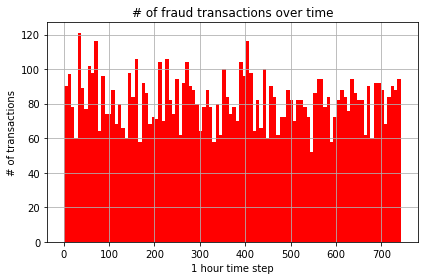

In [43]:
#Looking at step (time)
valid.hist(column="step",color="green", bins=100)
plt.xlabel("1 hour time step")
plt.ylabel("# of transactions")
plt.title("# of valid transactions over time")

fraud.hist(column ="step",color="red", bins=100)
plt.xlabel("1 hour time step")
plt.ylabel("# of transactions")
plt.title("# of fraud transactions over time")

plt.tight_layout()
plt.show()

Fraudulent transactions don't seem to vary too much over time, whereas valid ones do

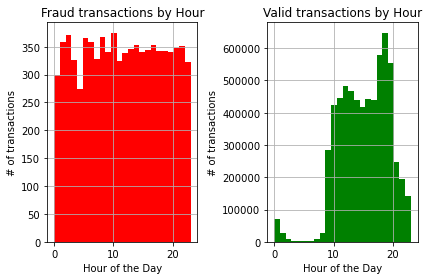

In [44]:
#seeing how time of day effects fraud
fraud_hours = fraud.step % 24
valid_hours = valid.step % 24

plt.subplot(1, 2, 1)
fraud_hours.hist(bins=24, color="red")
plt.title('Fraud transactions by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel("# of transactions")


plt.subplot(1, 2, 2)
valid_hours.hist(bins=24, color="green")
plt.title('Valid transactions by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel("# of transactions")

plt.tight_layout()
plt.show()

From this figure, it looks like valid transactions rarely occur between hours 0 and 9, whereas fraudulent transactions don't vary too much across hours of the day.
I'll add a new feature of 'hourOfDay', as this could improve the accuracy of predictions

# Drop features I don't need, add the 'hourOfDay' feature, OHE 'type'

In [45]:
df = df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

In [46]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [47]:
df["hourOfDay"] = df.step % 24
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,hourOfDay
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,1
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,1
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,1


In [51]:
newdf = df.copy()
newdf.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,hourOfDay
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,1
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,1
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,1


In [52]:
newdf = pd.get_dummies(newdf,prefix=['type'])
newdf.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,hourOfDay,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,1,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,1,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,1,0,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,1,0,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,1,0,0,0,1,0


# Random Forest

In [56]:
x = newdf.drop('isFraud', 1)
y = newdf.isFraud
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

scaler.fit(x_train)


x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

C:\Users\matt_\AppData\Local\Temp/ipykernel_9996/679989824.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x = newdf.drop('isFraud', 1)


RandomForest accuracy: 0.9997713206194933


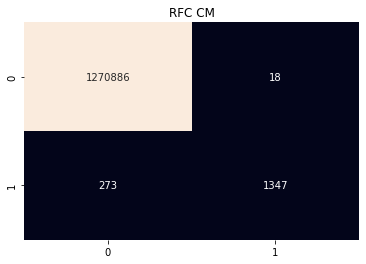

In [57]:
rfc=RandomForestClassifier(random_state=42)
rfc.fit(x_train, y_train)
rfcPred = rfc.predict(x_test)
rfc_cm = confusion_matrix(y_test, rfcPred)
rfc_ac = accuracy_score(rfcPred, y_test)

plt.title('RFC CM')
sns.heatmap(rfc_cm,annot=True,fmt="d",cbar=False)
print('RandomForest accuracy:', rfc_ac)

# ANN

In [58]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 8, kernel_initializer='uniform', activation = 'relu', input_dim = 12))

# Adding the second hidden layer
classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [61]:
#Fitting the model
classifier.fit(x_train, y_train, batch_size=100, epochs=10)

Epoch 1/10
50901/50901 [==============================] - 51s 1000us/step - loss: 0.0033 - accuracy: 0.9993
Epoch 2/10
50901/50901 [==============================] - 50s 978us/step - loss: 0.0028 - accuracy: 0.9994
Epoch 3/10
50901/50901 [==============================] - 47s 916us/step - loss: 0.0026 - accuracy: 0.9994
Epoch 4/10
50901/50901 [==============================] - 49s 965us/step - loss: 0.0025 - accuracy: 0.9994
Epoch 5/10
50901/50901 [==============================] - 55s 1ms/step - loss: 0.0024 - accuracy: 0.9995
Epoch 6/10
50901/50901 [==============================] - 50s 988us/step - loss: 0.0023 - accuracy: 0.9995
Epoch 7/10
50901/50901 [==============================] - 62s 1ms/step - loss: 0.0023 - accuracy: 0.9995
Epoch 8/10
50901/50901 [==============================] - 49s 960us/step - loss: 0.0023 - accuracy: 0.9995
Epoch 9/10
50901/50901 [==============================] - 48s 952us/step - loss: 0.0022 - accuracy: 0.9995
Epoch 10/10
50901/50901 [===============

Accuracy of ANN model:  0.9995882199471287


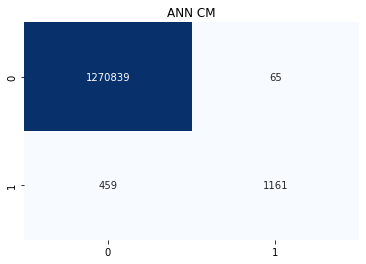

In [68]:
#Predicting
annPred = classifier.predict(x_test)
ann_cm = confusion_matrix(y_test, annPred.round())
sns.heatmap(ann_cm,annot=True,cmap="Blues",fmt="d",cbar=False)

plt.title('ANN CM')
ann_ac = accuracy_score(y_test, annPred.round())
print('Accuracy of ANN model: ', ann_ac)